In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

from sklearn.decomposition import PCA

2024-08-16 11:24:37.447891: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 11:24:37.761773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

In [3]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [4]:
def calculate_variance_sample(dmap_list, dmap_ref, num_probes):
    variance_list = [num_probes**-2 * np.linalg.norm(x - dmap_ref)**2 for x in dmap_list]
    return np.mean(variance_list)

In [5]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [6]:
esc_median_map = np.median(esc_maps_interp, axis=0)
cnc_median_map = np.median(cnc_maps_interp, axis=0)

In [9]:
template_flatten = [esc_median_map, cnc_median_map]

In [10]:
esc_variance_sample = [calculate_variance_sample(esc_maps_interp, x, 80) for x in template_flatten]
cnc_variance_sample = [calculate_variance_sample(cnc_maps_interp, x, 80) for x in template_flatten]

In [12]:
esc_variance_sample

[87502.49114406222, 96716.8218309013]

In [13]:
cnc_variance_sample

[83269.23262794556, 82782.40741315651]

In [5]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240812_WeightMCMC_2med_var'

In [8]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [6]:
# List all folders in the common directory
folders = [f for f in os.listdir(common_dir) if os.path.isdir(os.path.join(common_dir, f))]
folders.sort()

In [9]:
lw_dict = {}
for f in folders:
    dir = os.path.join(common_dir, f)
    stan_directory_esc = os.path.join(dir, 'ESC/stan_output')
    stan_directory_cnc = os.path.join(dir, 'CNC/stan_output')
    stan_directory_all = os.path.join(dir, 'all/stan_output')
    
    esc_log_weights = load_weights(stan_directory_esc, 2)
    cnc_log_weights = load_weights(stan_directory_cnc, 2)
    # all_log_weights = load_weights(stan_directory_all, 2500)  
    
    lw_dict[f] = {'ESC': esc_log_weights, 'CNC': cnc_log_weights}
    

['20240715_WeightOptimization-20240812110352_1.csv', '20240715_WeightOptimization-20240812110352_2.csv', '20240715_WeightOptimization-20240812110352_3.csv', '20240715_WeightOptimization-20240812110352_4.csv']
['20240715_WeightOptimization-20240812110355_1.csv', '20240715_WeightOptimization-20240812110355_2.csv', '20240715_WeightOptimization-20240812110355_3.csv', '20240715_WeightOptimization-20240812110355_4.csv']
['20240715_WeightOptimization-20240812110404_1.csv', '20240715_WeightOptimization-20240812110404_2.csv', '20240715_WeightOptimization-20240812110404_3.csv', '20240715_WeightOptimization-20240812110404_4.csv']
['20240715_WeightOptimization-20240812110407_1.csv', '20240715_WeightOptimization-20240812110407_2.csv', '20240715_WeightOptimization-20240812110407_3.csv', '20240715_WeightOptimization-20240812110407_4.csv']
['20240715_WeightOptimization-20240812110416_1.csv', '20240715_WeightOptimization-20240812110416_2.csv', '20240715_WeightOptimization-20240812110416_3.csv', '202407

In [10]:
import corner

In [15]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240812'

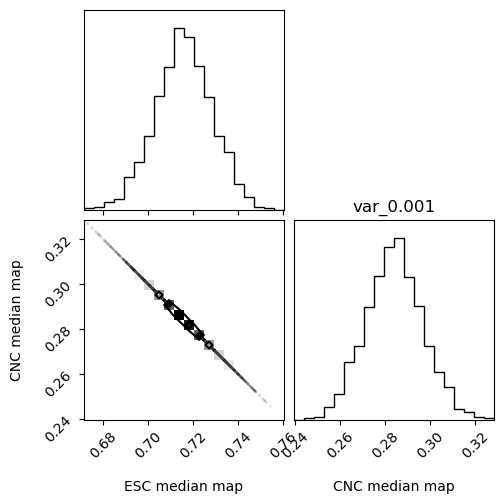

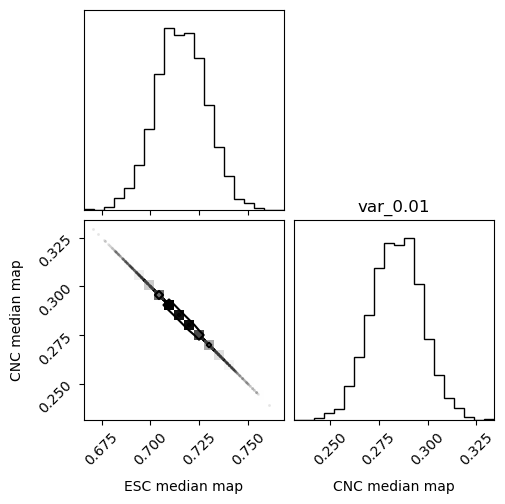

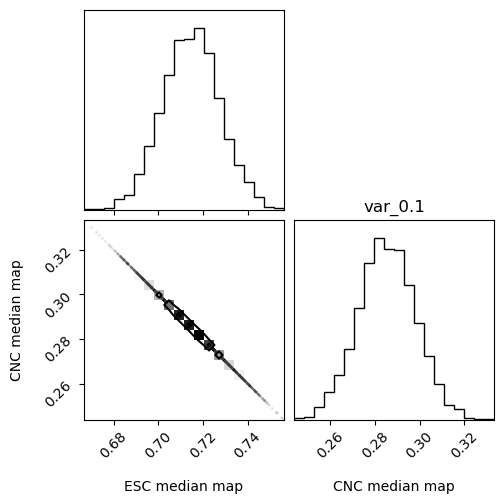

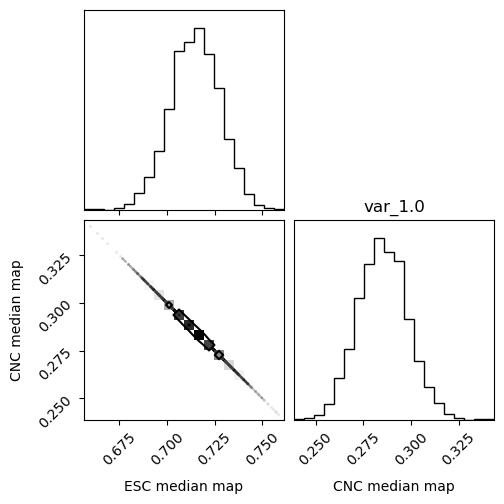

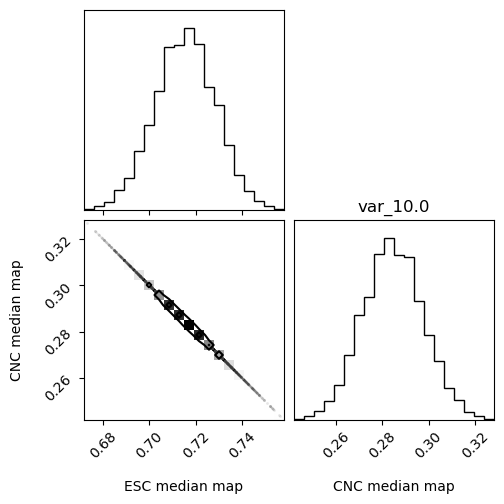

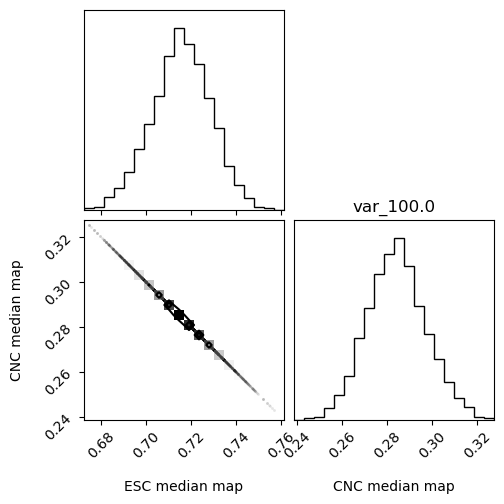

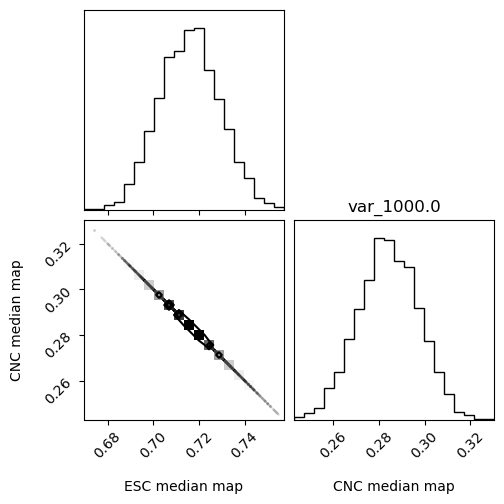

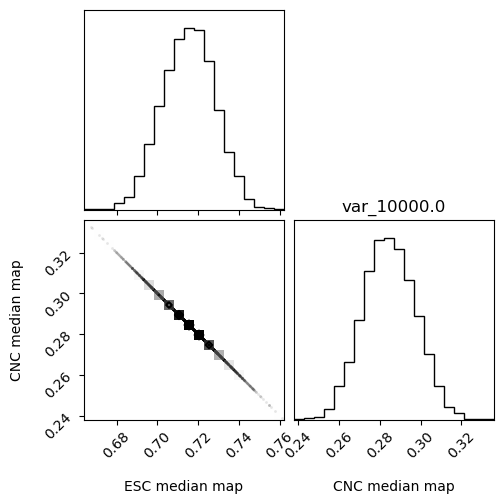

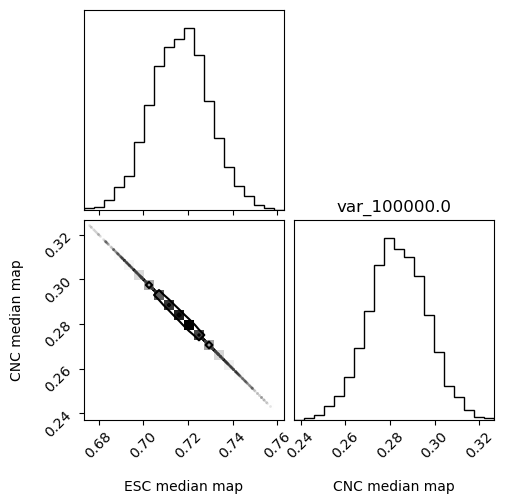

In [17]:
df_dict = {}
for f in lw_dict:
    esc_weights = lw_dict[f]['ESC']
    cnc_weights = lw_dict[f]['CNC']
    
    esc_weights = np.exp(esc_weights.reshape(-1, 2))
    cnc_weights = np.exp(cnc_weights.reshape(-1, 2))
    
    corner.corner(esc_weights, labels=['ESC median map', 'CNC median map'])
    plt.title(f)
    plt.savefig(os.path.join(save_dir, 'esc_weight_distribution_2med_%s.png'%f), dpi=300, bbox_inches='tight')

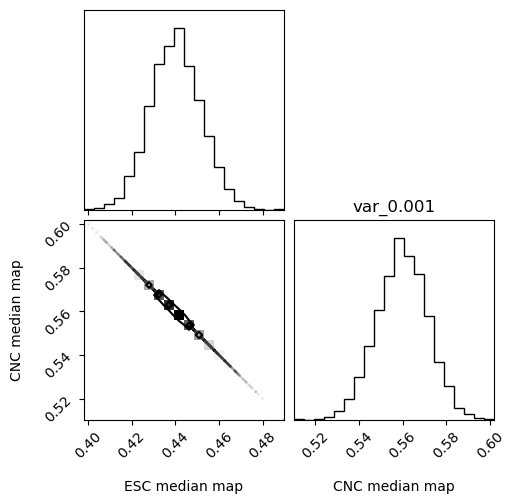

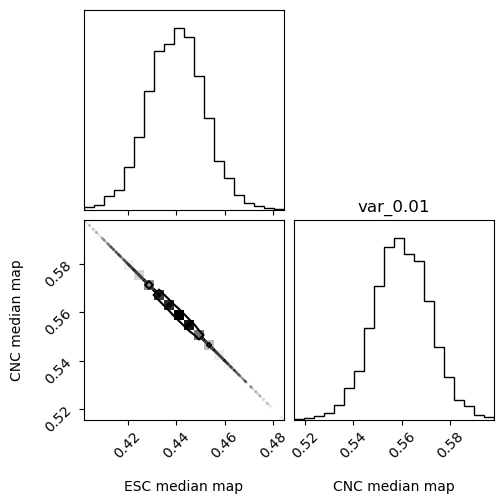

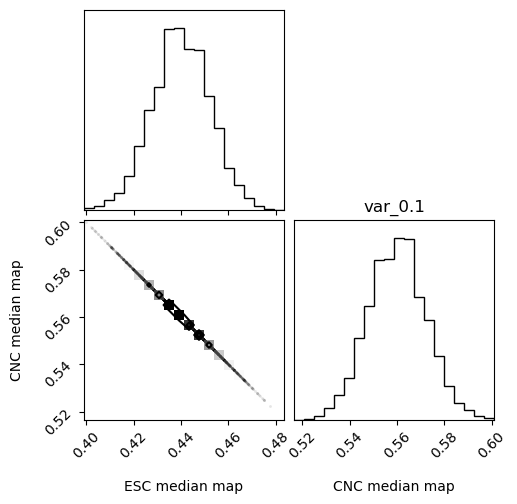

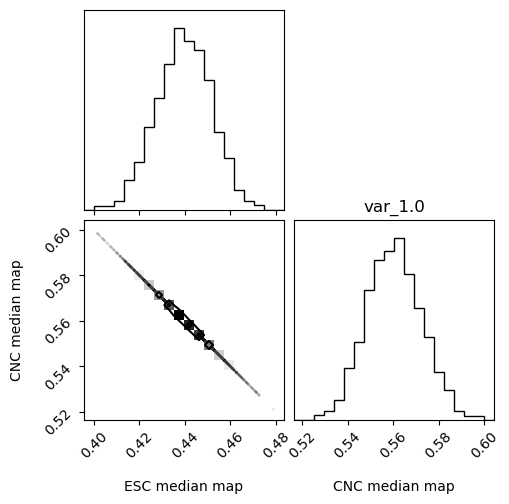

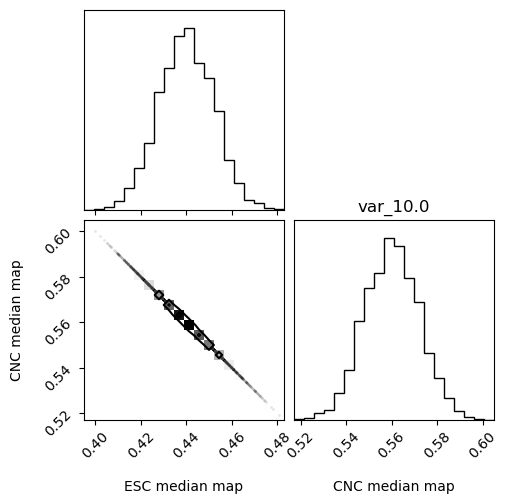

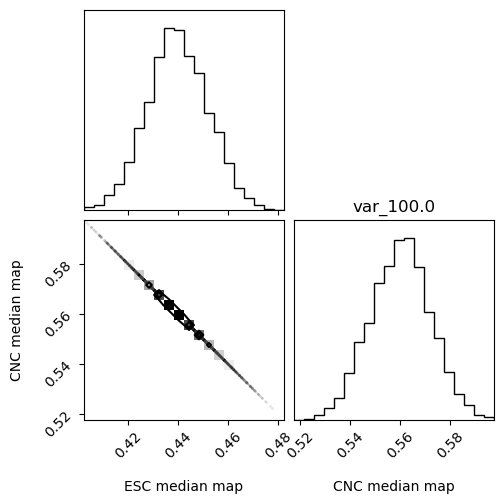

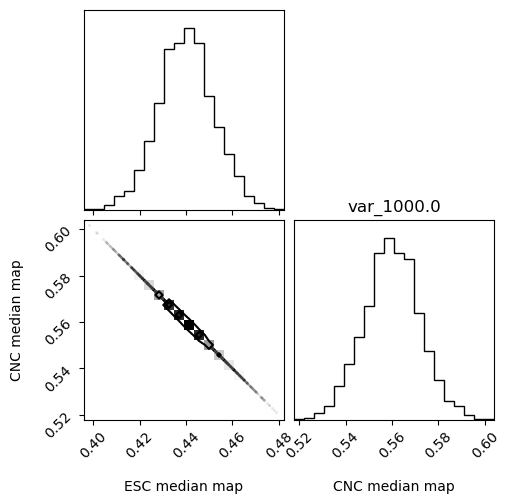

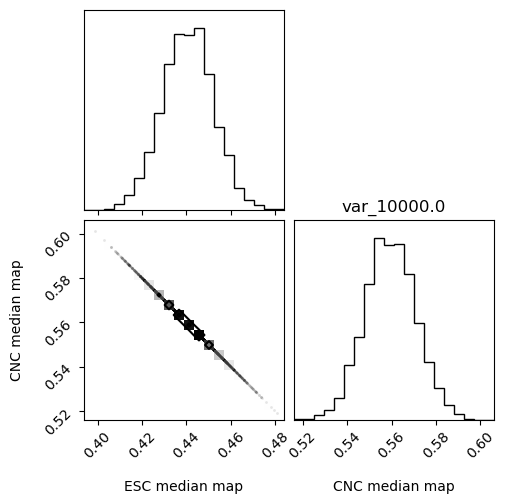

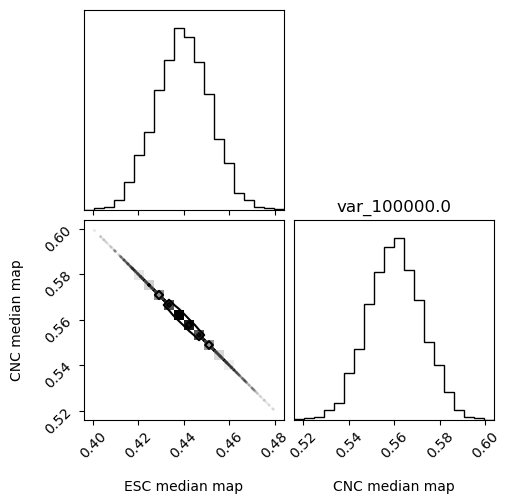

In [18]:
df_dict = {}
for f in lw_dict:
    esc_weights = lw_dict[f]['ESC']
    cnc_weights = lw_dict[f]['CNC']
    
    esc_weights = np.exp(esc_weights.reshape(-1, 2))
    cnc_weights = np.exp(cnc_weights.reshape(-1, 2))
    
    corner.corner(cnc_weights, labels=['ESC median map', 'CNC median map'])
    plt.title(f)
    plt.savefig(os.path.join(save_dir, 'cnc_weight_distribution_2med_%s.png'%f), dpi=300, bbox_inches='tight')